Importing required packages

In [79]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

Filtering out some test participants (used to test the survey system), added dataset column and deleted "instruction" and "configHash Column"

In [80]:
# Load the CSV file
file_path = './data/final-study-raw.csv'
df = pd.read_csv(file_path)

# df.head(10)



Add a field named isCorrectlyAnswered

In [81]:
# List of factual trialIds
factual_trial_ids = [
    'Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1',
    'Tennis-Vis-Q1', 'Tennis-Text-Q1', 'Tennis-Both-Q1',
    'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'
]

# List of factual responseIds (for simplicity, assuming they are the same across all these trialIds)
factual_response_ids = ['voq1', 'voq2', 'voq3', 'voq4', 'voq5', 'voq6', 'voq7', 'voq8']

training_trial_ids = ['Training 1', 'Training 2', 'Training 3']
training_response_ids = ['1', '2', '3']



# Function to determine if the answer is correct or should be marked as "undefined"
def is_correctly_answered(row):
    if (row['trialId'] in factual_trial_ids and row['responseId'] in factual_response_ids) or \
       (row['trialId'] in training_trial_ids and row['responseId'] in training_response_ids):
        # Check if the trial is one of the special cases where order doesn't matter
        if row['trialId'] in ['Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1', 
                              'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'] and \
           row['responseId'] in ['voq3']:  # Add any other responseId that requires set comparison
            
            # Split the answers into sets and compare them
            correct_answer_set = set(row['correctAnswer'].split(','))
            answer_set = set(row['answer'].split(','))
            return correct_answer_set == answer_set
        
        else:
            # For all other cases, do a direct string comparison
            return row['answer'] == row['correctAnswer']
    else:
        return "undefined"

# Add the isCorrectlyAnswered column
df['isCorrectlyAnswered'] = df.apply(is_correctly_answered, axis=1)

# Reorder columns to place isCorrectlyAnswered right after correctAnswer
cols = df.columns.tolist()
correct_answer_index = cols.index('correctAnswer')
cols.insert(correct_answer_index + 1, cols.pop(cols.index('isCorrectlyAnswered')))
df = df[cols]

df.head(10)  # Displaying the first 50 rows for verification

,participantId,trialId,trialOrder,responseId,status,percentComplete,description,instruction,responsePrompt,answer,correctAnswer,isCorrectlyAnswered,responseMin,responseMax,startTime,endTime,duration,configHash
0,0af16079-0483-461b-93c6-eca94561e312,Consent,1,id,rejected,29.41,undefined,undefined,Please enter your Prolific ID,cvv,undefined,undefined,undefined,undefined,2024-08-13T15:46:20.211Z,2024-08-13T15:46:27.152Z,6941,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
1,0af16079-0483-461b-93c6-eca94561e312,Consent,1,consent,rejected,29.41,undefined,undefined,Do you consent to the study and wish to continue?,yes,undefined,undefined,undefined,undefined,2024-08-13T15:46:20.211Z,2024-08-13T15:46:27.152Z,6941,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
2,0af16079-0483-461b-93c6-eca94561e312,Training 1,3,1,rejected,29.41,undefined,Please answer the following questions:,What is the largest set?,Action,Action,True,undefined,undefined,2024-08-13T16:47:36.097Z,2024-08-13T16:48:02.663Z,26566,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
3,0af16079-0483-461b-93c6-eca94561e312,Training 1,3,2,rejected,29.41,undefined,Please answer the following questions:,What is the largest intersection?,Empty Intersection (no sets),Empty Intersection (no sets),True,undefined,undefined,2024-08-13T16:47:36.097Z,2024-08-13T16:48:02.663Z,26566,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
4,0af16079-0483-461b-93c6-eca94561e312,Training 1,3,3,rejected,29.41,undefined,Please answer the following questions:,How many sets make up the largest intersection?,It is the empty intersection (no sets),It is the empty intersection (no sets),True,undefined,undefined,2024-08-13T16:47:36.097Z,2024-08-13T16:48:02.663Z,26566,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
5,0af16079-0483-461b-93c6-eca94561e312,Training 2,4,1,rejected,29.41,undefined,Please answer the following questions:,What is the largest set?,Adventure,Adventure,True,undefined,undefined,2024-08-13T16:48:02.680Z,2024-08-13T16:48:16.430Z,13750,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
6,0af16079-0483-461b-93c6-eca94561e312,Training 2,4,2,rejected,29.41,undefined,Please answer the following questions:,What is the largest intersection?,Adventure,Adventure,True,undefined,undefined,2024-08-13T16:48:02.680Z,2024-08-13T16:48:16.430Z,13750,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
7,0af16079-0483-461b-93c6-eca94561e312,Training 2,4,3,rejected,29.41,undefined,Please answer the following questions:,How many sets make up the largest intersection?,It is only of a single set,It is only of a single set,True,undefined,undefined,2024-08-13T16:48:02.680Z,2024-08-13T16:48:16.430Z,13750,b011fd085c893b46f29f1bc1c954aff0cac6737dd8ff96e79015ddce64d6ea10
8,2033c860-b467-42e3-ab2e-19ca44e65b0a,Consent,1,id,rejected,100.00,undefined,undefined,Your Prolific ID,Rahat Zaman,undefined,undefined,undefined,undefined,2024-07-31T03:26:03.202Z,2024-07-31T03:27:28.983Z,85781,ecdced17dc1fd86b8b83f4914646d257990133f94230749d2417f2136be6214d
9,2033c860-b467-42e3-ab2e-19ca44e65b0a,Consent,1,consent,rejected,100.00,undefined,undefined,Do you consent to the study and wish to continue?,yes,undefined,undefined,undefined,undefined,2024-07-31T03:26:03.202Z,2024-07-31T03:27:28.983Z,85781,ecdced17dc1fd86b8b83f4914646d257990133f94230749d2417f2136be6214d


Filtering out the completed studies (removing the pending and rejected ones)

In [82]:
# Filter rows where 'Status' is 'completed'
filtered_df = df[df['status'] == 'completed']

# Count the number of unique participants
unique_participant_count = filtered_df['participantId'].nunique()

# Print the number of unique participants
print(f"Number of unique participants: {unique_participant_count}")

# Define the participantId to be removed
participants_to_remove = ['e78b4a59-2483-4f3b-a4b1-e046e06e1e26', '66a13fdf279c038ba8aa5ae6']

# Filter out the rows with the specified participantId
filtered_df = filtered_df[~filtered_df['participantId'].isin(participants_to_remove)]

# Add the dataset column based on the conditions
def determine_dataset(trial_id):
    if 'Covid' in trial_id:
        return 'Covid Symptoms'
    elif 'Tennis' in trial_id:
        return 'Tennis Grand Slam Winners'
    elif 'Organizations' in trial_id:
        return 'International Organizations'
    elif 'Training' in trial_id:
        return 'Movie Genres'
    else:
        return 'Undefined'

filtered_df['dataset'] = filtered_df['trialId'].apply(determine_dataset)

# Delete the specified columns
filtered_df = filtered_df.drop(columns=['instruction', 'configHash'])

# Save the filtered data to a new CSV file
new_file_path = './data/final-study.csv'
filtered_df.to_csv(new_file_path, index=False)

print(f"Filtered data saved to: {new_file_path}")


Number of unique participants: 54
Filtered data saved to: ./data/final-study.csv


(Ignore now) Separating three conditions (Vis, Text, Both) in three different files 

In [83]:
# Define the middle part of the conditions
conditions = ['Text', 'Both', 'Vis', 'Survey']

# Generate separate CSV files for each condition
for condition in conditions:
    # Filter the DataFrame based on the presence of the condition in 'trialId'
    condition_df = filtered_df[filtered_df['trialId'].str.contains(condition)]
    
    # Save the filtered data to a new CSV file
    new_file_path = f'./data/{condition}_data.csv'
    condition_df.to_csv(new_file_path, index=False)
    
    print(f"Filtered data for condition '{condition}' saved to: {new_file_path}")

Filtered data for condition 'Text' saved to: ./data/Text_data.csv
Filtered data for condition 'Both' saved to: ./data/Both_data.csv
Filtered data for condition 'Vis' saved to: ./data/Vis_data.csv
Filtered data for condition 'Survey' saved to: ./data/Survey_data.csv


Counting post survey preferences and effectiveness

In [84]:


# Load the CSV data
data = pd.read_csv('./data/Survey_data.csv')

# Filter relevant columns for analysis
columns_of_interest = ['participantId', 'trialId', 'responseId', 'responsePrompt', 'answer']
filtered_data = data[columns_of_interest]

# Analyze responses to "Which presentation modality did you find most effective?"
most_effective = filtered_data[filtered_data['responsePrompt'] == 'Which presentation modality did you find most effective?']['answer']

# Analyze responses to "Which condition did you find the least effective?"
least_effective = filtered_data[filtered_data['responsePrompt'] == 'Which condition did you find the least effective?']['answer']

# Analyze responses to "If you were to receive information in the future, which format would you prefer?"
preferred_format = filtered_data[filtered_data['responsePrompt'] == 'If you were to receive information in the future, which format would you prefer?']['answer']

# Create counters for each question
most_effective_counts = Counter(most_effective)
least_effective_counts = Counter(least_effective)
preferred_format_counts = Counter(preferred_format)

most_effective_counts, least_effective_counts, preferred_format_counts


(Counter({'Text and Visualization Combined': 36,
          'Just Visualization': 13,
          'Just Text Description': 5}),
 Counter({'Just Text Description': 38,
          'Just Visualization': 13,
          'Text and Visualization Combined': 3}),
 Counter({'Text and Visualization Combined': 37,
          'Just Visualization': 12,
          'Just Text Description': 5}))

Plotting the result for pereferences and the effectiveness

Most Effective: [13, 36, 5]
Least Effective: [13, 3, 38]
Preferred Format: [12, 37, 5]


/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_71173/2735830496.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted[df_melted['Category'] == title], x='Condition', y='Count', ax=ax, palette='viridis', ci=None)
/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_71173/2735830496.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_melted[df_melted['Category'] == title], x='Condition', y='Count', ax=ax, palette='viridis', ci=None)
/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_71173/2735830496.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
/var/folders/t8/_mskc

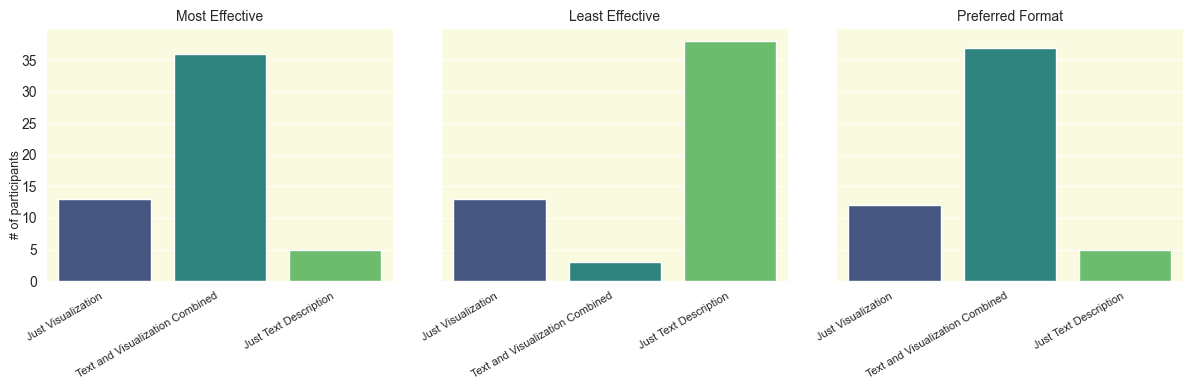

In [85]:
# Example DataFrame

conditions = ['Just Visualization', 'Text and Visualization Combined', 'Just Text Description']
# Initialize lists for counts
most_effective_list = [most_effective_counts.get(cond, 0) for cond in conditions]
least_effective_list = [least_effective_counts.get(cond, 0) for cond in conditions]
preferred_format_list = [preferred_format_counts.get(cond, 0) for cond in conditions]

# Print results to verify
print('Most Effective:', most_effective_list)
print('Least Effective:', least_effective_list)
print('Preferred Format:', preferred_format_list)

data = {
    'Condition': conditions,
    'Most Effective': most_effective_list,
    'Least Effective': least_effective_list,
    'Preferred Format': preferred_format_list
}
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars='Condition', var_name='Category', value_name='Count')

# Seaborn settings
# sns.set_style("whitegrid")
sns.set_style("whitegrid", {'axes.facecolor': (0.98, 0.98, 0.88), 'grid.color': 'white'})

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, facecolor='white')

# Define titles
titles = ['Most Effective', 'Least Effective', 'Preferred Format']

# Plotting
palette = sns.color_palette("husl", len(conditions)) 
for ax, title in zip(axs, titles):
    sns.barplot(data=df_melted[df_melted['Category'] == title], x='Condition', y='Count', ax=ax, palette='viridis', ci=None)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    # ax.set_ylabel('# of participants', fontsize=8)
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
    ax.set_facecolor((0.98, 0.98, 0.88))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


# Set common y-label
fig.text(0.01, 0.5, '# of participants', va='center', rotation='vertical', fontsize=9)

# # Remove gridlines
# for ax in axs:
#     ax.grid(False)

fig.savefig('./figures/effectiveness-analysis.pdf', dpi=500, bbox_inches='tight')

plt.tight_layout()
plt.show()



In [86]:
# Load the main CSV file
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the columns to display
columns_of_interest = ['participantId','trialId', 'responseId', 'responsePrompt', 'answer', 'correctAnswer', 'dataset']
ans_df = df[columns_of_interest]

# Display the filtered dataframe
ans_df.head()


,participantId,trialId,responseId,responsePrompt,answer,correctAnswer,dataset
0,574dc90512d86b000f833ab0,Consent,id,Please enter your Prolific ID,574dc90512d86b000f833ab0,undefined,Undefined
1,574dc90512d86b000f833ab0,Consent,consent,Do you consent to the study and wish to continue?,yes,undefined,Undefined
2,574dc90512d86b000f833ab0,Training 1,1,What is the largest set?,Action,Action,Movie Genres
3,574dc90512d86b000f833ab0,Training 1,2,What is the largest intersection?,Empty Intersection (no sets),Empty Intersection (no sets),Movie Genres
4,574dc90512d86b000f833ab0,Training 1,3,How many sets make up the largest intersection?,It is the empty intersection (no sets),It is the empty intersection (no sets),Movie Genres


Percentage of Answering Correcty (based on Text, Both and Vis for each dataset (covid-text-Q1, covid-vis-Q1, etc. and training dataset)

In [87]:
# Load the data from prep-pilot.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the trialIds of interest
trial_ids_of_interest = [
    'Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1',
    'Tennis-Vis-Q1', 'Tennis-Text-Q1', 'Tennis-Both-Q1',
    'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'
]

# Filter the dataframe to include only rows with the specified trialIds
dataset_df = df[df['trialId'].isin(trial_ids_of_interest)]

print("Only the below trialIds have factual questions:")
print(dataset_df['trialId'].value_counts()/8)
dataset_df.head(10)

# Convert 'isCorrectlyAnswered' from string to boolean
dataset_df['isCorrectlyAnswered'] = dataset_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

# Ensure isCorrectlyAnswered is boolean and filter out non-boolean values
filterCorrectAnswer_df = dataset_df[dataset_df['isCorrectlyAnswered'].isin([True, False])]
filterCorrectAnswer_df.head(10)

# print(filterCorrectAnswer_df['isCorrectlyAnswered'].value_counts())

# Calculate the percentage of correctly answered trials for each trialId
percentage_correct_by_trialid = filterCorrectAnswer_df.groupby('trialId')['isCorrectlyAnswered'].mean() * 100

# Display the results
print("Percentage of correctly answered trials for each trialId of having factual questions:")
print(percentage_correct_by_trialid)


Only the below trialIds have factual questions:
trialId
Covid-Vis-Q1             23.0
Tennis-Both-Q1           20.0
Tennis-Text-Q1           20.0
Organizations-Both-Q1    20.0
Covid-Text-Q1            17.0
Organizations-Vis-Q1     17.0
Organizations-Text-Q1    17.0
Covid-Both-Q1            14.0
Tennis-Vis-Q1            14.0
Name: count, dtype: float64
Percentage of correctly answered trials for each trialId of having factual questions:
trialId
Covid-Both-Q1            91.964286
Covid-Text-Q1            84.558824
Covid-Vis-Q1             94.565217
Organizations-Both-Q1    89.375000
Organizations-Text-Q1    87.500000
Organizations-Vis-Q1     87.500000
Tennis-Both-Q1           82.500000
Tennis-Text-Q1           87.500000
Tennis-Vis-Q1            78.571429
Name: isCorrectlyAnswered, dtype: float64


/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_71173/4096212739.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['isCorrectlyAnswered'] = dataset_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)


Percentage of Answering Correcty (based on each Visual Contents - Vis, Text or Both)

In [88]:
# Create a new column to identify the visual content type (VIS, BOTH, Text)
def get_visual_content_type(trialId):
    if 'Vis' in trialId:
        return 'VIS'
    elif 'Both' in trialId:
        return 'BOTH'
    elif 'Text' in trialId:
        return 'TEXT'
    

filterCorrectAnswer_df['VisualContentType'] = filterCorrectAnswer_df['trialId'].apply(get_visual_content_type)

# Calculate the percentage of correctly answered trials for each Visual Content Type
percentage_correct_by_visual_content = filterCorrectAnswer_df.groupby('VisualContentType')['isCorrectlyAnswered'].mean() * 100

# Display the results
print("Percentage of correctly answered cumulatively for each Visual Content Type:")
print(percentage_correct_by_visual_content)

Percentage of correctly answered cumulatively for each Visual Content Type:
VisualContentType
BOTH    87.500000
TEXT    86.574074
VIS     88.194444
Name: isCorrectlyAnswered, dtype: float64


Percentage of Answering Correcty (based on datasets)

In [89]:

# Calculate the percentage of correctly answered trials for each dataset
percentage_correct_by_dataset = filterCorrectAnswer_df.groupby('dataset')['isCorrectlyAnswered'].mean() * 100

# Display the result
print("Percentage of correctly answered answer cumulatively for each dataset (of having factual questions only):")
print(percentage_correct_by_dataset)



Percentage of correctly answered answer cumulatively for each dataset (of having factual questions only):
dataset
Covid Symptoms                 90.740741
International Organizations    88.194444
Tennis Grand Slam Winners      83.333333
Name: isCorrectlyAnswered, dtype: float64


Printing the answers of "What are the insights and takeaways about the data"?

In [90]:


# Load the data from prep-pilot.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the Q3 trialIds of interest
q3_trial_ids = [
    'Covid-Vis-Q3', 'Covid-Text-Q3', 'Covid-Both-Q3',
    'Tennis-Vis-Q3', 'Tennis-Text-Q3', 'Tennis-Both-Q3',
    'Organizations-Vis-Q3', 'Organizations-Text-Q3', 'Organizations-Both-Q3'
]

# Filter the dataframe to include only rows with the specified Q3 trialIds
q3_df = df[df['trialId'].isin(q3_trial_ids)]

# Print the answers for all the Q3 trialIds
pd.set_option('display.max_colwidth', None)
(q3_df[['trialId','answer']])


,trialId,answer
22,Covid-Text-Q3,The set sizes have a lot of variation but the intersection properties seem very similar.
34,Organizations-Vis-Q3,There is a large divergence in the sets and the intersections.
46,Tennis-Both-Q3,Set sizes are mostly equal.
78,Covid-Both-Q3,It is a little repetitive.
90,Organizations-Vis-Q3,I think the set is about government organizations but I'm not sure.
...,...,...
2946,Organizations-Both-Q3,"With the accompanying text, the dataset was extremely easy to understand."
2958,Tennis-Text-Q3,"The all-set data is less obvious in a written format, as I expect it to be featured with the rest of the intersection data and not on its own."
2990,Organizations-Text-Q3,These stats represent well the info from all organisation
3002,Tennis-Both-Q3,explain well the stat


Completion time VS overall correctness

Only the below trialIds have factual questions:
trialId
Covid-Vis-Q1             23.0
Tennis-Both-Q1           20.0
Tennis-Text-Q1           20.0
Organizations-Both-Q1    20.0
Covid-Text-Q1            17.0
Organizations-Vis-Q1     17.0
Organizations-Text-Q1    17.0
Covid-Both-Q1            14.0
Tennis-Vis-Q1            14.0
Name: count, dtype: float64
participantId
574dc90512d86b000f833ab0     5.630767
5955a3eb98c9c400019f5c5f     4.494150
597fe89a1b41a20001749f57     4.611833
5aebc4ac75deca00016252ea    11.702000
5ba855d47c0ebe0001272f70     5.253867
5c6c260dce4e560001f75731     5.514500
5dd71896670d1a6af9f20eee     7.058683
5e02e5144acfb9e385bb4c5a     5.846250
5ece9e3b3a19db0cf5af6692    10.590333
5ed7b0c59a2ae024836e32d5     7.053917
5f4fc497a3b4320c8928639e     4.240483
60fcd02deba2c8e1ed1f0723     4.289000
61080d1c39e080da7841eade     2.953250
611116ac01f43eeeb3cdeff3     3.595117
628254ec789e78a3dcd22d99     4.763850
62bb4c95ca36f792585cb4b5     5.672183
63ea445c759d5bf0e3f63739

/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_71173/1996821533.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['isCorrectlyAnswered'] = overall_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)


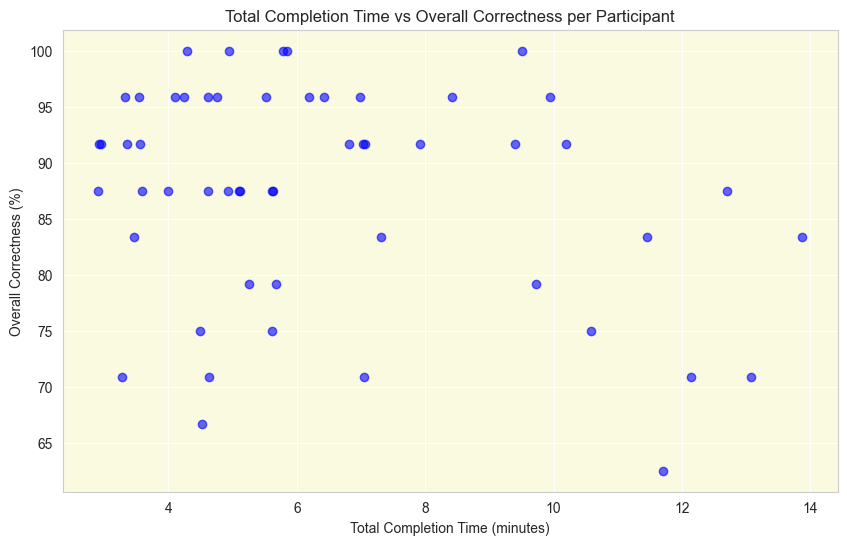

In [91]:
# Load the data from prep-pilot.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the trialIds of interest
trial_ids_of_interest = [
    'Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1',
    'Tennis-Vis-Q1', 'Tennis-Text-Q1', 'Tennis-Both-Q1',
    'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'
]

# Filter the dataframe to include only rows with the specified trialIds
overall_df = df[df['trialId'].isin(trial_ids_of_interest)]

print("Only the below trialIds have factual questions:")
print(overall_df['trialId'].value_counts()/8)
overall_df.head(10)

# Convert 'isCorrectlyAnswered' from string to boolean
overall_df['isCorrectlyAnswered'] = overall_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

# Ensure isCorrectlyAnswered is boolean and filter out non-boolean values
overallCorrectAnswer_df = overall_df[overall_df['isCorrectlyAnswered'].isin([True, False])]
overallCorrectAnswer_df.head(10)

# Calculate correctness per participant per condition
overallCorrectAnswer_df['correctAnswerNumeric'] = overallCorrectAnswer_df['isCorrectlyAnswered'].astype(int)  # Convert correctness to numeric (1 for True, 0 for False)
correctness_by_participant = overallCorrectAnswer_df.groupby(['participantId', 'trialId'])['correctAnswerNumeric'].sum()

# Pivot the table to get a better structure for summing up correctness
correctness_pivot = correctness_by_participant.unstack().fillna(0)

# # Calculate the overall correctness per participant (sum the scores)
# correctness_pivot['overallCorrectness'] = correctness_pivot.sum(axis=1)
# Calculate the overall correctness percentage per participant (sum the scores and calculate percentage)
correctness_pivot['overallCorrectness'] = (correctness_pivot.sum(axis=1) / 24) * 100

# Select the first occurrence of each trialId per participant for duration calculation
first_occurrence_df = overallCorrectAnswer_df.groupby(['participantId', 'trialId']).first().reset_index()


# # Calculate the total completion time per participant
# total_time_by_participant = overallCorrectAnswer_df.groupby('participantId')['duration'].sum()/1000  # Convert milliseconds to seconds

# Calculate the total completion time per participant in minutes by summing the first durations
total_time_by_participant = first_occurrence_df.groupby('participantId')['duration'].sum() / 60000  # Convert milliseconds to minutes
print(total_time_by_participant)

# Combine correctness and duration into a single DataFrame
summary_df = pd.DataFrame({
    'totalCompletionTime': total_time_by_participant,
    'overallCorrectness': correctness_pivot['overallCorrectness']
})

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.scatter(summary_df['totalCompletionTime'], summary_df['overallCorrectness'], color='blue', alpha=0.6)
plt.title('Total Completion Time vs Overall Correctness per Participant')
# plt.xlabel('Total Completion Time (seconds)')
plt.xlabel('Total Completion Time (minutes)')
# plt.ylabel('Overall Correctness (out of 24)')
plt.ylabel('Overall Correctness (%)')
plt.grid(True)
plt.show()




Only the below trialIds have factual questions:
trialId
Covid-Vis-Q1             23.0
Tennis-Both-Q1           20.0
Tennis-Text-Q1           20.0
Organizations-Both-Q1    20.0
Covid-Text-Q1            17.0
Organizations-Vis-Q1     17.0
Organizations-Text-Q1    17.0
Covid-Both-Q1            14.0
Tennis-Vis-Q1            14.0
Name: count, dtype: float64

Participant Duration Table:
           participantId               trialId  duration
574dc90512d86b000f833ab0         Covid-Text-Q1  3.337117
574dc90512d86b000f833ab0  Organizations-Vis-Q1  1.188833
574dc90512d86b000f833ab0        Tennis-Both-Q1  1.104817
5955a3eb98c9c400019f5c5f         Covid-Both-Q1  1.138367
5955a3eb98c9c400019f5c5f  Organizations-Vis-Q1  2.094317
5955a3eb98c9c400019f5c5f        Tennis-Text-Q1  1.261467
597fe89a1b41a20001749f57         Covid-Both-Q1  1.480900
597fe89a1b41a20001749f57  Organizations-Vis-Q1  1.473150
597fe89a1b41a20001749f57        Tennis-Text-Q1  1.657783
5aebc4ac75deca00016252ea          Covid-Vis-Q1 

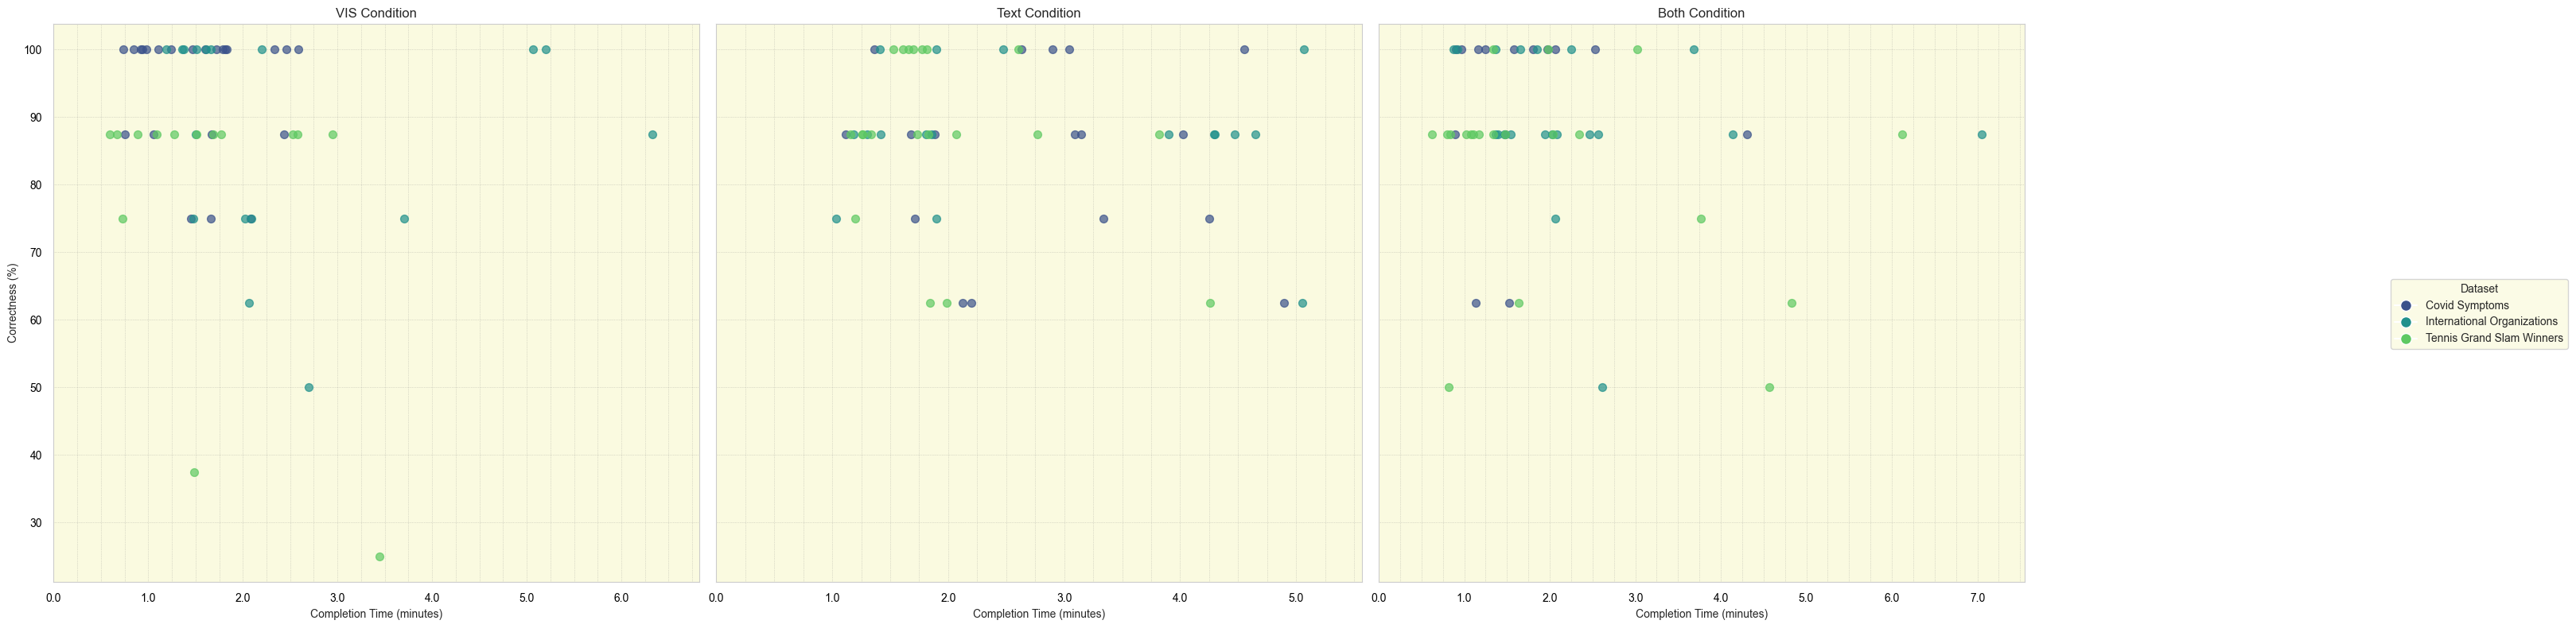

In [92]:
# Load the data from final-study.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the trialIds of interest for each condition
conditions = {
    'VIS': ['Covid-Vis-Q1', 'Tennis-Vis-Q1', 'Organizations-Vis-Q1'],
    'Text': ['Covid-Text-Q1', 'Tennis-Text-Q1', 'Organizations-Text-Q1'],
    'Both': ['Covid-Both-Q1', 'Tennis-Both-Q1', 'Organizations-Both-Q1']
}

# Prepare the DataFrame to include only relevant trialIds
overall_df = df[df['trialId'].isin(sum(conditions.values(), []))]

print("Only the below trialIds have factual questions:")
print(overall_df['trialId'].value_counts()/8)
overall_df.head(10)

# Convert 'isCorrectlyAnswered' from string to boolean using .loc to avoid SettingWithCopyWarning
overall_df.loc[:, 'isCorrectlyAnswered'] = overall_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

# Ensure isCorrectlyAnswered is boolean and filter out non-boolean values
overallCorrectAnswer_df = overall_df[overall_df['isCorrectlyAnswered'].isin([True, False])]

# Calculate correctness per participant per condition
overallCorrectAnswer_df['correctAnswerNumeric'] = overallCorrectAnswer_df['isCorrectlyAnswered'].astype(int)
correctness_by_participant = overallCorrectAnswer_df.groupby(['participantId', 'trialId'])['correctAnswerNumeric'].sum().reset_index()

# Select the first occurrence of each trialId per participant for duration calculation
first_occurrence_df = overallCorrectAnswer_df.groupby(['participantId', 'trialId']).first().reset_index()

# Calculate the total completion time per participant in minutes by summing the first durations
first_occurrence_df['duration'] = first_occurrence_df['duration'] / 60000  # Convert milliseconds to minutes

# Select and sort the relevant columns
duration_table = first_occurrence_df[['participantId', 'trialId', 'duration']]
duration_table = duration_table.sort_values(['participantId', 'trialId'])

print("\nParticipant Duration Table:")
print(duration_table.to_string(index=False))

# Merge duration and correctness into one DataFrame, ensure correctness column is added
merged_df = pd.merge(first_occurrence_df, correctness_by_participant, on=['participantId', 'trialId'], suffixes=('', '_correct'))
merged_df['correctness'] = (merged_df['correctAnswerNumeric_correct'] / 8) * 100  # Calculate correctness percentage

# Create a plot for each condition
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=True)

# Get unique dataset names from the DataFrame
all_datasets = sorted(merged_df['dataset'].unique())
print("Datasets found in the data:", all_datasets)

# Create a color palette for consistent colors across subplots
palette = sns.color_palette("viridis", n_colors=len(all_datasets))
color_dict = dict(zip(all_datasets, palette))

legend_handles = []

for ax, (condition, trial_ids) in zip(axes, conditions.items()):
    # Filter data for the current condition
    condition_df = merged_df[merged_df['trialId'].isin(trial_ids)]
    
    # Create scatter plot
    for dataset in all_datasets:
        dataset_df = condition_df[condition_df['dataset'] == dataset]
        scatter = ax.scatter(
            dataset_df['duration'],
            dataset_df['correctness'],
            c=[color_dict[dataset]],
            label=dataset,
            s=50,  # Increased point size for visibility
            alpha=0.7  # Add some transparency to help with overlapping
        )
    
    # Set titles and labels
    ax.set_title(f'{condition} Condition')
    ax.set_xlabel('Completion Time (minutes)')
    if condition == 'VIS':
        ax.set_ylabel('Correctness (%)')
    else:
        ax.set_ylabel('')
        
    # Adjust x-axis to be more granular
    max_duration = max(condition_df['duration'])
    ax.set_xlim(0, max_duration + 0.5)
    
    # Set major ticks every minute and minor ticks every 15 seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    
    # Format x-axis labels to show one decimal place
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    
    # Make ticks more visible
    ax.tick_params(which='both', direction='out', length=4, width=1, colors='black')
    ax.tick_params(which='major', length=7)
    
    # Add gridlines for better readability
    ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

# Create legend handles manually
for dataset in all_datasets:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[dataset], markersize=10, label=dataset))

# Add a global legend to the right of the entire figure
fig.legend(handles=legend_handles, labels=all_datasets, title='Dataset', 
           loc='center right', bbox_to_anchor=(1.08, 0.5))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Save the figure
fig.savefig('./figures/correctness-by-each-condition.png', bbox_inches='tight', dpi=300)

plt.show()


(Ignore) Heatmap generation

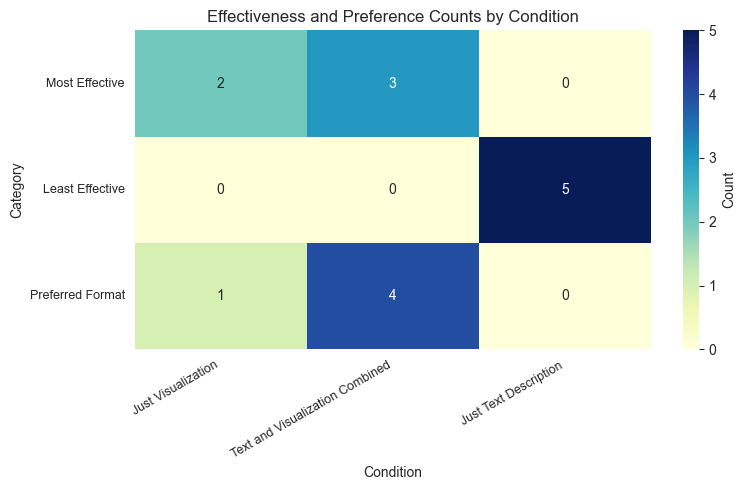

In [30]:
# Prepare data for heatmap
heatmap_data = df.set_index('Condition').T

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='YlGnBu', cbar_kws={'label': 'Count'})

# Set titles and labels
plt.title('Effectiveness and Preference Counts by Condition', fontsize=12)
plt.xlabel('Condition', fontsize=10)
plt.ylabel('Category', fontsize=10)

plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()